<a href="https://colab.research.google.com/github/cdr6934/DisasterRecoverTweets/blob/main/MSDS_DisasterTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Data Import

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240423%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240423T132631Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D85e44446a4823e4a4a519152532087aa380eb77806ffcd3406a25d15117128dcce91110b20ef23939b89392f6fdb17e629e9426b1bbe63a71b3555539bbeb17789edcb3c90bfad80708d1f6cc5495b13b8a0e53b87d0f625af5e95166d58664bacdebb8fa617212613fe8eb30ba2b703fdfcac6d8e6dffa779a115fbafe1d5b7e6092b6f32fc91e556259667558f6e9e697ad9935ac757c7983d28145414d2a5662e57cd12d3c8c98253f6a3cf3aa80a0a93f804ee3c1a8960ba74729bdb34be88201413f92ff83ff209f4a8d67ab8c199593a28a25579356cb7cb86889c6ac40538e88f3945dcd7e2fa7bdba6aa0aead2d8f5f5d1dc3f0d01b399c9e2bf0459'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Disaster Recovery Tweets (MSDS 2024 - Introduction to Deep Learning)

[Github](https://github.com/cdr6934/DisasterRecoverTweets/blob/main/MSDS_DisasterTweets.ipynb)

## Problem / Data

For this challenge, we are going to use tweets from X (formerly Twitter) to identify certain tweets that indicate that there is a disaster or emergency. This provides an opportunity to create early detection systems on public information that will help first responders to prepare for large relief efforts.

The dataset that we are going to be using is a dataset of tweets (10.7K) that have been labeled with Emergency / No Emergency. We are going to be using around 7K of these tweets to help train our neural network. We are given a category, a location from where the tweet originated, a class, and the text that highlights the text.

Our objective is to build a binary classifier using the text running it through a LSTM model, and then take the text and predict if it is an emergency tweet or not.

In [4]:
import os
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:

import re
import gensim
import string
from tqdm import tqdm

# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## NLP Libraries
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
stop=set(stopwords.words('english'))

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')

## NN Libraries (Keras)
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D,GRU
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam

## Exploratory Data Analysis (EDA)
In order to understand the data, we will do the following

* Get the size / shape of the data
* Understand the split (Emergency / No Emergency)
* Distribution of the frequency of samples

In [7]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train.head(1000)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
995,1445,body%20bagging,NaN,Body Bagging Bitches ???? http://t.co/aFssGPnZWi,0
996,1447,body%20bagging,PURPLE BOOTH STUDIOã¢,No better feeling than seeing and being on sta...,0
997,1448,body%20bagging,Cloud 9,Mopheme and Bigstar Johnson are a problem in t...,0
998,1449,body%20bagging,NaN,I was body Bagging on the ????Today...4got to ...,0


Some insights from the dataset can be seen:
* There are alot of hashtags which could be unconventional spellings. Things like `#WisdomWed` or `#ArrestPastorNganga` which can be difficult for a model to digest since its not normal text.
* There are a number of links that are in the dataset like ` http://t.co/f6ntUc734Z`, `http://t.co/TfcdRONRA6`
* There are alot of user mentions throughout the dataset for example @KJForDays or 	@CalFreedomMom
* There are other characters that might not have much meaning such as characters, dates, emojis (aka  Û 29-07-2015, 21:1023) all of these might not be useful to the building of the model.

We will take care of these further down.

In [9]:
df=pd.concat([df_train,df_test])
df.shape

(10876, 5)

<ipython-input-8-a851e484e86a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x.index, y=x, palette='viridis')


Text(0, 0.5, 'samples')

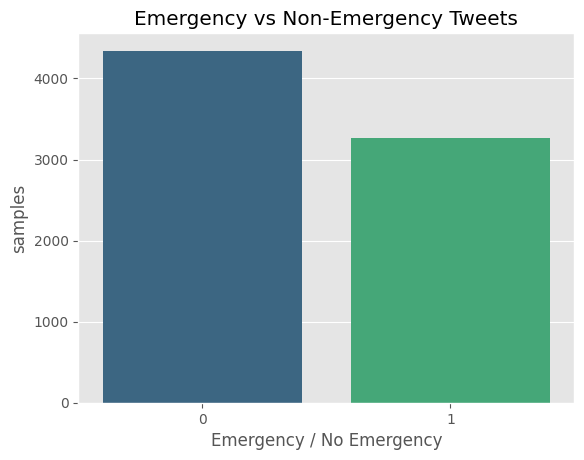

In [8]:
x= df_train.target.value_counts()

# Set title
plt.title('Emergency vs Non-Emergency Tweets')
plt.xlabel("Emergency / No Emergency")
plt.ylabel("Tweets")


sns.set_color_codes("pastel")
sns.barplot(x=x.index, y=x, palette='viridis')

plt.gca().set_ylabel('samples')

In [9]:
x

target
0    4342
1    3271
Name: count, dtype: int64

Between the training and test tweets, there are 10,876; for the training set we see that we have a mixture of these tweets to be labeled as emergency (3271) vs not emergency (4342). Though the sampleset isn't completely balanced, we do see that the emergency comprise of around 43% of the total training set.

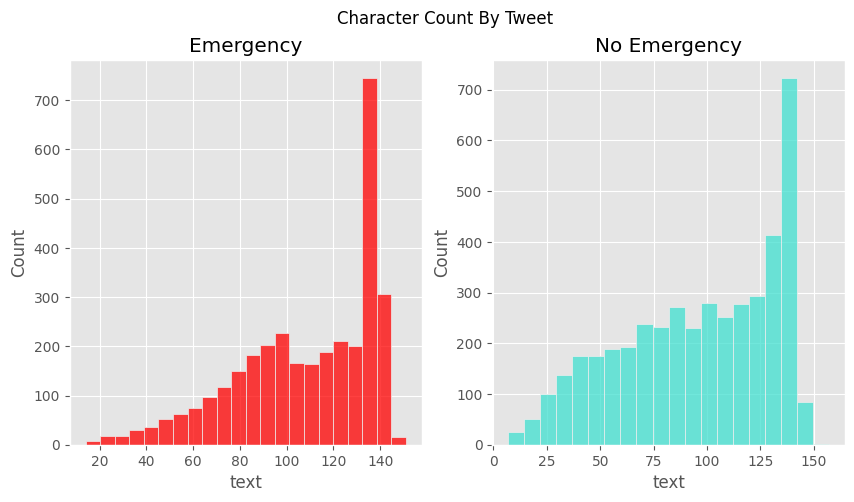

In [19]:
# Set up the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Histogram for 'Emergency' tweets
tweet_len_emergency = df_train[df_train['target'] == 1]['text'].str.len()
sns.histplot(tweet_len_emergency, color='red', ax=ax1)
ax1.set_title('Emergency')

# Histogram for 'No Emergency' tweets
tweet_len_no_emergency = df_train[df_train['target'] == 0]['text'].str.len()
sns.histplot(tweet_len_no_emergency, color='turquoise', ax=ax2)
ax2.set_title('No Emergency')

# Set the main title for the figure
fig.suptitle('Character Count By Tweet')

# Display the plot
plt.show()


We do see that the distribution of the length of these tweets does seem to have a specific difference. In the emergency tweets, we see that there is a distinct power law distibution trend from the 20 - 100 character tweets and flattens out till about 140 characters from which it spikes.

As for no emergency tweets, we also see the power law in effect, however there is a distinct upward trend in the data and spikes at about the same place.

This could be that the data selected for this challenge has been selected but it is interesting to see that the distibution following a powerlaw.

(10876, 5)

### Preprocessing Data
For any successful implementation of  a textual model, cleaning the data and providing it with normalized information is crucial. I've taken the following approach based on some of the information in the tweets.

**Remove URLs and HTML**: This step involves identifying and eliminating any web addresses from the text. URLs can be distracting and are usually irrelevant to most NLP tasks, such as text classification or sentiment analysis. Text often comes embedded with HTML tags, especially if extracted from web pages or for that matter tweets. These tags are not part of the actual content and should be removed to prevent them from skewing text analysis processes.

**Remove Emojis**: Emojis are graphical symbols that may not contribute to certain types of text analysis and can be removed to simplify the text, especially in contexts where only textual data is relevant.

**Remove Punctuation**: Punctuation marks can be removed from the text to reduce the number of unique tokens that a model needs to handle. However, this might depend on the specific application, as punctuation can be crucial for understanding sentiments or grammatical nuances in some cases.


Text Processing Steps
Once the text is cleaned, it proceeds through the following stages:

**Tokenization**: This step involves dividing the text into smaller pieces, called tokens, which can be as small as words or as large as sentences. Tokenization helps in structuring the raw text in a way that is easier for algorithms to process.

**Lemmatization**: In this process, words are reduced to their base or dictionary form (lemma). Unlike stemming, lemmatization considers the context and converts the word to its meaningful base form, which is useful for grouping together different forms of the same word so they can be analyzed as a single item.

In [32]:
def remove_web_ref(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    text = url.sub(r'',text)
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


#Remove emojis from the dataset
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# Remove punctuation from the dataset
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

## Remove
df['text']=df['text'].apply(lambda x : remove_web_ref(x))
df['text']=df['text'].apply(lambda x: remove_emoji(x))
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [33]:
lemmatizer = WordNetLemmatizer()

def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        lemmatized_text = [lemmatizer.lemmatize(token) for token in words]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 6827.89it/s]


## GloVe

Now, we need to take the dataset and create an embedding or representation of the dataset so that the LSTM network can read the representation.

GloVe, or "Global Vectors for Word Representation," is a model for learning word vectors developed by researchers at Stanford University. It's designed to efficiently capture global statistical information of a dataset by constructing a word co-occurrence matrix and then applying matrix factorization techniques. The key idea behind GloVe is to derive semantic relationships between words from the aggregation of global word-word co-occurrence statistics from a corpus.

In [34]:
embedding_dict={}

with open('/content/drive/MyDrive/MSDS Deep Learning /glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [35]:
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

In [36]:
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

Number of unique words: 20342


In [37]:
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue

    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 20342/20342 [00:00<00:00, 463179.98it/s]


In [38]:
# Split the data
train=tweet_pad[:df_train.shape[0]]
test=tweet_pad[df_train.shape[0]:]


# Sub-sample 10% of the training data
X_subsample, _ = train_test_split(train, test_size=0.9, random_state=52)  # 10% to X_subsample, 90% to _
y_subsample, _ = train_test_split(df_train['target'].values, test_size=0.9, random_state=52)  # Corresponding targets

X_train,X_test,y_train,y_test=train_test_split(train,df_train['target'].values,test_size=0.15, random_state=52) # make sure the


# Model Architecture

The model that we have created here is a basic sequential model with a LSTM. We will start with a simple computational graph by creating a sequential graph, adding the embedding as the input, then adding a dropout layer to help performance of the model, an LSTM model, and then adding an activation sigmoid function.

Here we are going to start with an LSTM; we are going to use a simple Sequential mode, and then use the learning rate and drop out rate to come up with the best model. THen we will use the information as our basis from which we are going to experiment with a few of the parameters; drop out and learning rate. This will provide us a starting point and then a way for us to iterate on the model.


## Base Model

The following model here is a baseline build using an LSTM. You will find that this will provide us a starting point in which we can then further tweak by searching the hyperparameters that will provide us the ability to further refine. We will further refine in the Fine Tune Base Model below.

In [15]:
model=Sequential()
embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
train=tweet_pad[:df_train.shape[0]]
test=tweet_pad[df_train.shape[0]:]

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(train,df_train['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [ ]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

I reran the numbers for the base model below in the hyperparameter tuning below.

### Fine Tuning Base Model

We

In [116]:
def plot_img(full_history):

    history = full_history['model_results'].history
    drop = full_history['dropout']
    lr = full_history['lr']
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss over epochs - Dropout: {drop} / LR: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy over epochs - Dropout: {drop} / LR: {lr}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

#### 1. Base Model Fine Tuning (Learning Rate, Dropout Rate)  

Dropout - 0.3, 0.4
LR - 1e-4, 1e-5

In [62]:
def generate_model(model_dir, n_words, embedding_matrix, MAX_LEN, X_train, X_test, y_train, y_test, dropout=[0.3,0.4], learning_rate=[1e-4,1e-5]):
  models = {}
  for didx, drop in enumerate(dropout):
    for lidx, lr in enumerate(learning_rate):

      model_name = f'lstm_baseline_keras_{drop}_{lr}.keras'
      print(f'Working on - {model_name}')
      model = Sequential()
      embedding = Embedding(n_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)

      model.add(embedding)
      model.add(SpatialDropout1D(drop))  # Using the drop variable here for each model's specific dropout
      model.add(LSTM(64, dropout=drop, recurrent_dropout=drop))  # Adjusted to use drop here as well
      model.add(Dense(1, activation='sigmoid'))
      optimizer = Adam(learning_rate=lr)
      model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

      history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

      model_name = f'lstm_baseline_keras_{drop}_{lr}.keras'
      model.save(f'{model_dir}/{model_name}')

      models[(drop,lr)] = {'model_name': model_name, 'model_results': history, 'dropout':drop, 'lr': lr}

  return models

In [ ]:
models = generate_model(dropout=[0.3,0.4], learning_rate=[1e-4, 1e-5], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test )

{'model_name': 'lstm_baseline_keras_0.3_0.0001.h5', 'model_results': <keras.src.callbacks.History object at 0x7a3ffed74490>, 'dropout': 0.3, 'lr': 0.0001}


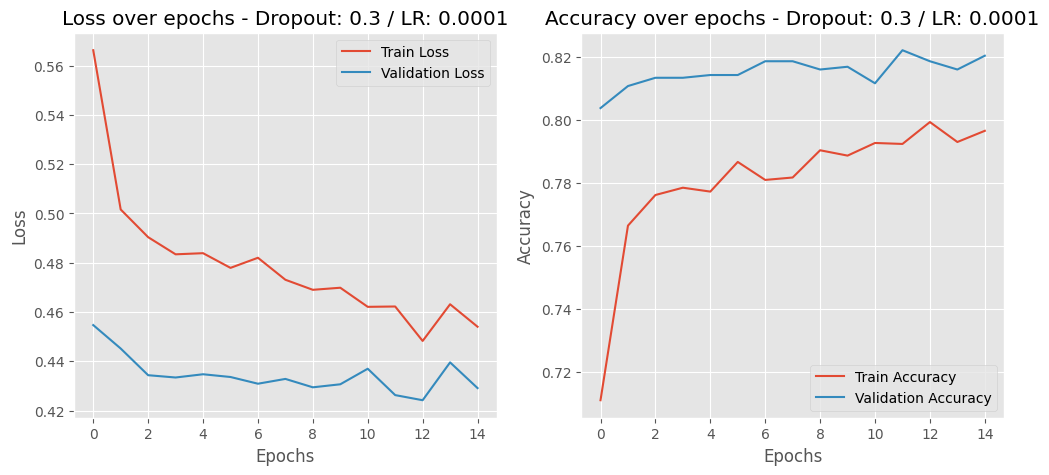

{'model_name': 'lstm_baseline_keras_0.3_1e-05.h5', 'model_results': <keras.src.callbacks.History object at 0x7a3ff03081c0>, 'dropout': 0.3, 'lr': 1e-05}


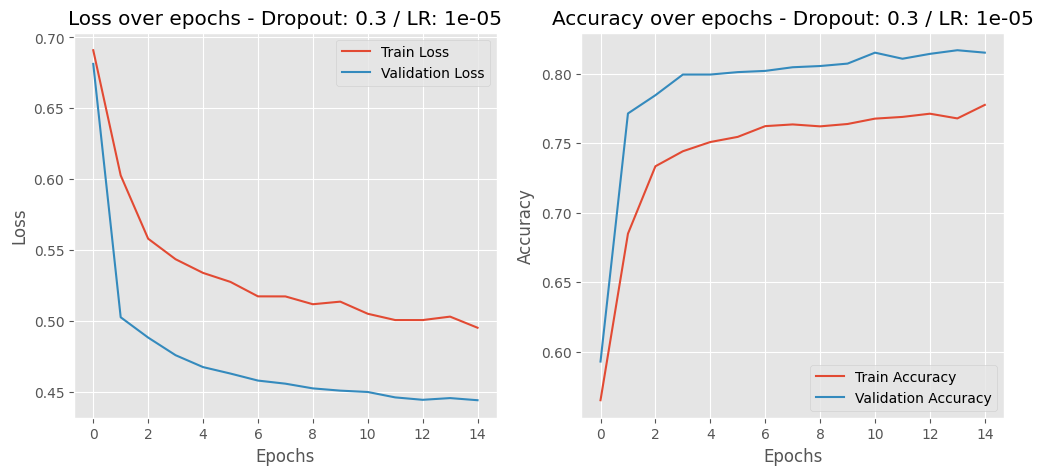

{'model_name': 'lstm_baseline_keras_0.4_0.0001.h5', 'model_results': <keras.src.callbacks.History object at 0x7a4000eb66e0>, 'dropout': 0.4, 'lr': 0.0001}


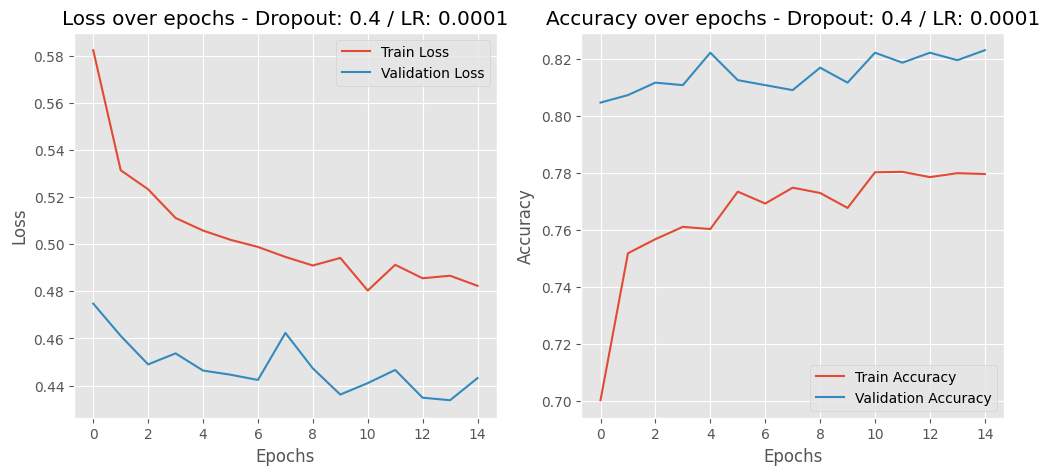

{'model_name': 'lstm_baseline_keras_0.4_1e-05.h5', 'model_results': <keras.src.callbacks.History object at 0x7a4000b37f70>, 'dropout': 0.4, 'lr': 1e-05}


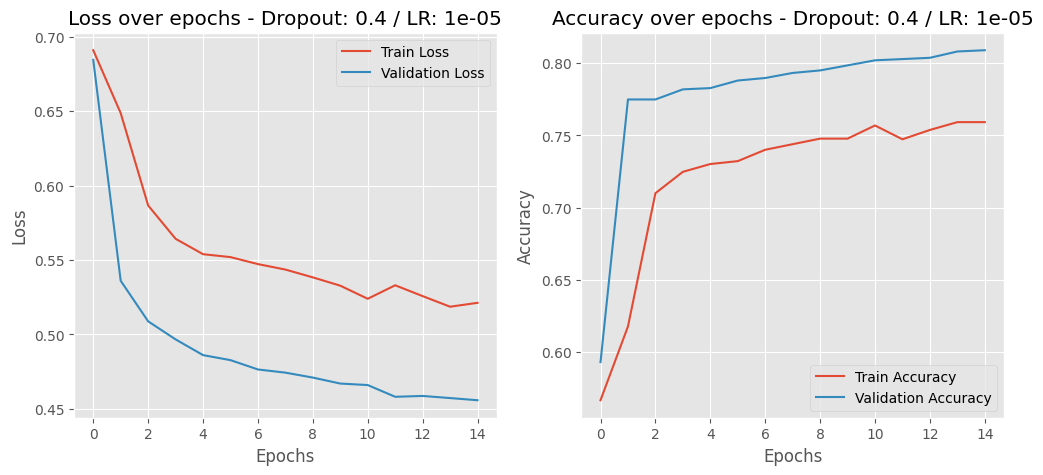

In [102]:
for i in models:
  print(models[i])
  plot_img(models[i])

In the above graphs, we see two graphs for each model, the loss and accuracy graph which indicate the difference between the training set metrics and the cross validation metrics that give us a better sense of the model that has been trained. For all, we will see that the training data will either have a higher loss or a lower accuracy then the validation metrics.

In [111]:
print('|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |')
print('|---|---|---|---|---|')
for i in models:
  history = models[i]['model_results'].history
  name = models[i]['model_name']
  drop = models[i]['dropout']
  lr = models[i]['lr']
  id = history['accuracy'].index(max(history['accuracy']))
  acc = round(history['accuracy'][id],4)
  val_acc = round(history['val_accuracy'][id],4)
  print(f'|{name}|{lr}|{drop}|{acc}|{val_acc}|')


|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|lstm_baseline_keras_0.3_0.0001.h5|0.0001|0.3|0.7994|0.8187|
|lstm_baseline_keras_0.3_1e-05.h5|1e-05|0.3|0.7776|0.8152|
|lstm_baseline_keras_0.4_0.0001.h5|0.0001|0.4|0.7804|0.8187|
|lstm_baseline_keras_0.4_1e-05.h5|1e-05|0.4|0.7592|0.8082|


|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|lstm_baseline_keras_0.3_0.0001.h5|0.0001|0.3|0.7994|0.8187|
|lstm_baseline_keras_0.3_1e-05.h5|1e-05|0.3|0.7776|0.8152|
|lstm_baseline_keras_0.4_0.0001.h5|0.0001|0.4|0.7804|0.8187|
|lstm_baseline_keras_0.4_1e-05.h5|1e-05|0.4|0.7592|0.8082|

#### 2. Base Model Fine Tuning (Learning Rate, Dropout Rate)  

Dropout - 0.2, 0.1
LR - 1e-5

In [ ]:
models_2 = generate_model(dropout=[0.2,0.1], learning_rate=[ 1e-5], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test )

{'model_name': 'lstm_baseline_keras_0.2_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c69e32458a0>, 'dropout': 0.2, 'lr': 1e-05}


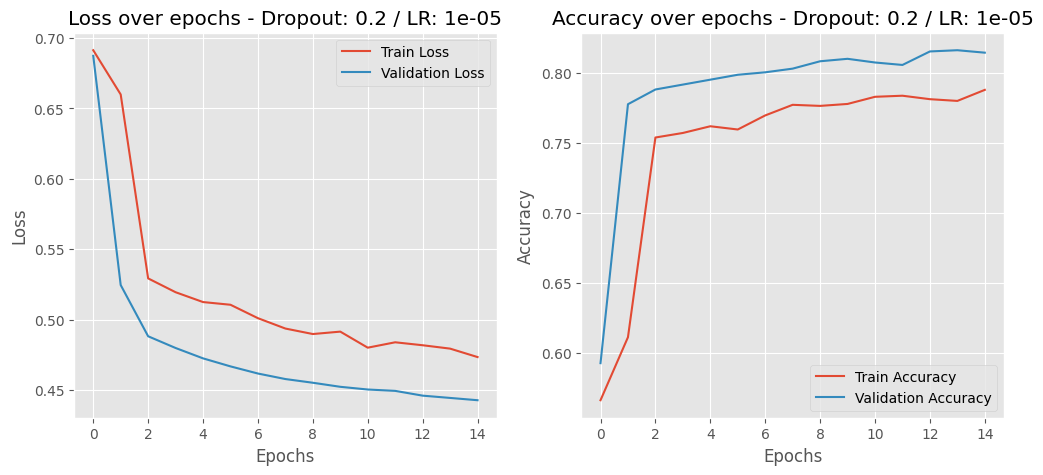

{'model_name': 'lstm_baseline_keras_0.1_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c69e306e1d0>, 'dropout': 0.1, 'lr': 1e-05}


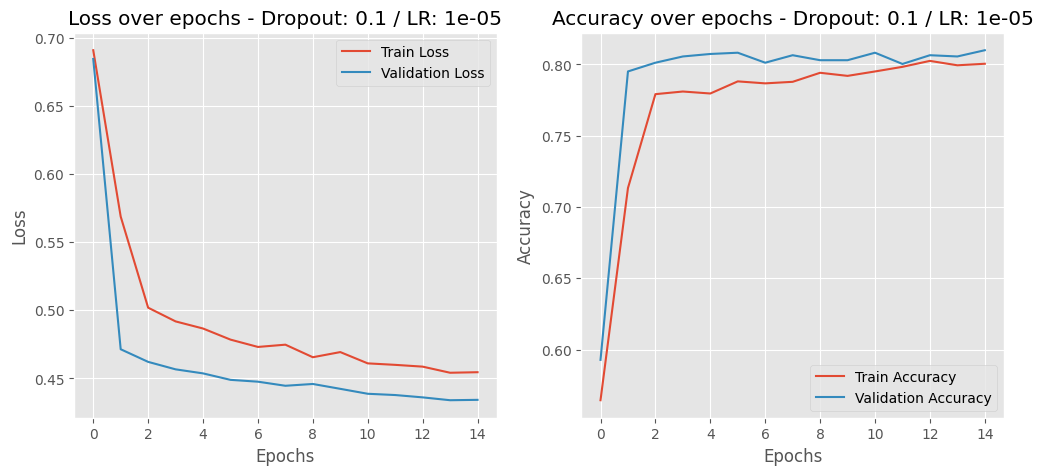

In [67]:
for i in models_2:
  print(models_2[i])
  plot_img(models_2[i])

In [68]:
print('|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |')
print('|---|---|---|---|---|')
for i in models_2:
  history = models_2[i]['model_results'].history
  name = models_2[i]['model_name']
  drop = models_2[i]['dropout']
  lr = models_2[i]['lr']
  id = history['accuracy'].index(max(history['accuracy']))
  acc = round(history['accuracy'][id],4)
  val_acc = round(history['val_accuracy'][id],4)
  print(f'|{name}|{lr}|{drop}|{acc}|{val_acc}|')

|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|lstm_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7878|0.8144|
|lstm_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.8025|0.8065|


|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|lstm_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7878|0.8144|
|lstm_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.8025|0.8065|

## Gated Recurrent Units (GRU)
Gated Recurrent Units (GRUs) and Long Short-Term Memory (LSTM) units are both popular types of recurrent neural network (RNN) architectures, widely used for tasks involving sequential data like speech recognition, language modeling, and time series analysis. Despite their similar goals of addressing the vanishing gradient problem inherent in traditional RNNs.

We know that GRUs are more efficient and resulting output would be the same between LSTMs and GRUs. Therefore we are going to start

In [98]:
def generate_model_gru(model_dir, n_words, embedding_matrix, MAX_LEN, X_train, X_test, y_train, y_test, dropout=[0.3, 0.4], learning_rate=[1e-4, 1e-5], epoch=15):
    models = {}
    for didx, drop in enumerate(dropout):
        for lidx, lr in enumerate(learning_rate):
            model_name = f'gru_baseline_keras_{drop}_{lr}.keras'
            print(f'Working on - {model_name}')
            model = Sequential([
                Embedding(n_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False),
                SpatialDropout1D(drop),
                GRU(128, dropout=drop),  # Removed recurrent_dropout
                Dense(1, activation='sigmoid')
            ])
            optimizer = Adam(learning_rate=lr)
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

            history = model.fit(X_train, y_train, batch_size=4, epochs=epoch, validation_data=(X_test, y_test), verbose=2)

            model.save(f'{model_dir}/{model_name}')
            models[(drop, lr)] = {'model_name': model_name, 'model_results': history, 'dropout': drop, 'lr': lr}

    return models


### Epoch 15

In [ ]:
model_gru = generate_model_gru(dropout=[0.2,0.1], learning_rate=[ 1e-5], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test, epoch=15 )

{'model_name': 'gru_baseline_keras_0.2_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c69dd1a93c0>, 'dropout': 0.2, 'lr': 1e-05}


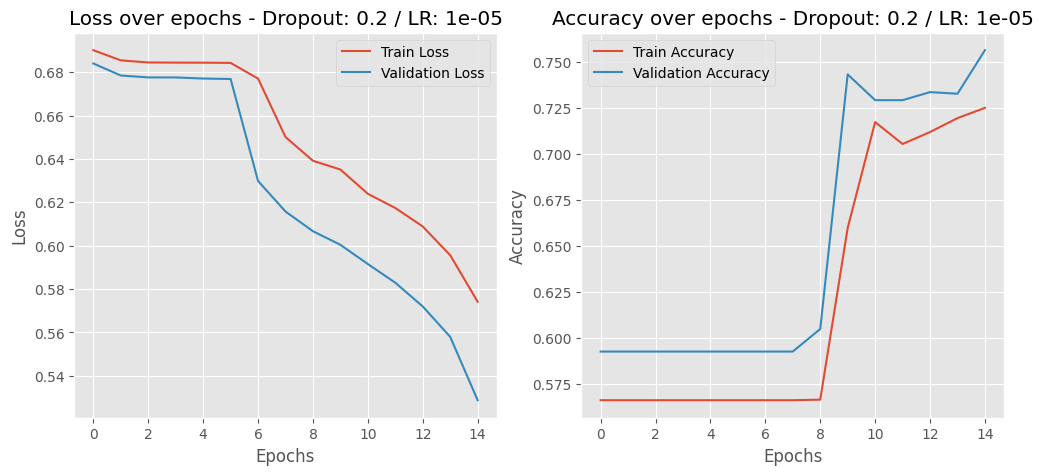

{'model_name': 'gru_baseline_keras_0.1_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c68ffb7b790>, 'dropout': 0.1, 'lr': 1e-05}


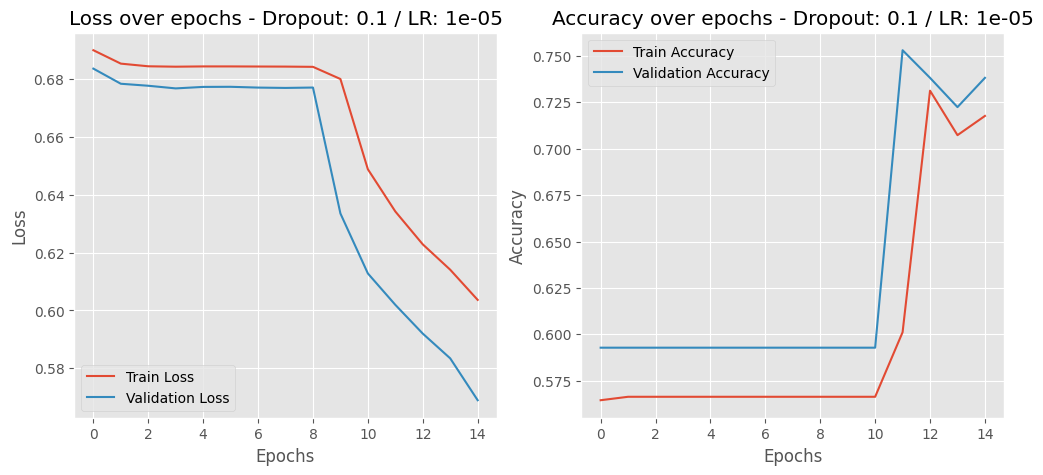

In [94]:
for i in model_gru:
  print(model_gru[i])
  plot_img(model_gru[i])

Based on the images here, we see the the GRU might need to run a few more epochs in order to better optimize the model as there may be more room to grow thus we run the same models again with 30 epochs to see if that makes a difference.

### Epoch 30

In [ ]:
model_gru = generate_model_gru(dropout=[0.2,0.1], learning_rate=[ 1e-5], model_dir = '/content/drive/MyDrive/MSDS Deep Learning/',
                        n_words=num_words, embedding_matrix=embedding_matrix, MAX_LEN=MAX_LEN, X_train=X_train,
                        X_test=X_test,y_train=y_train,y_test=y_test,epoch=30 )

{'model_name': 'gru_baseline_keras_0.2_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c6936b52170>, 'dropout': 0.2, 'lr': 1e-05}


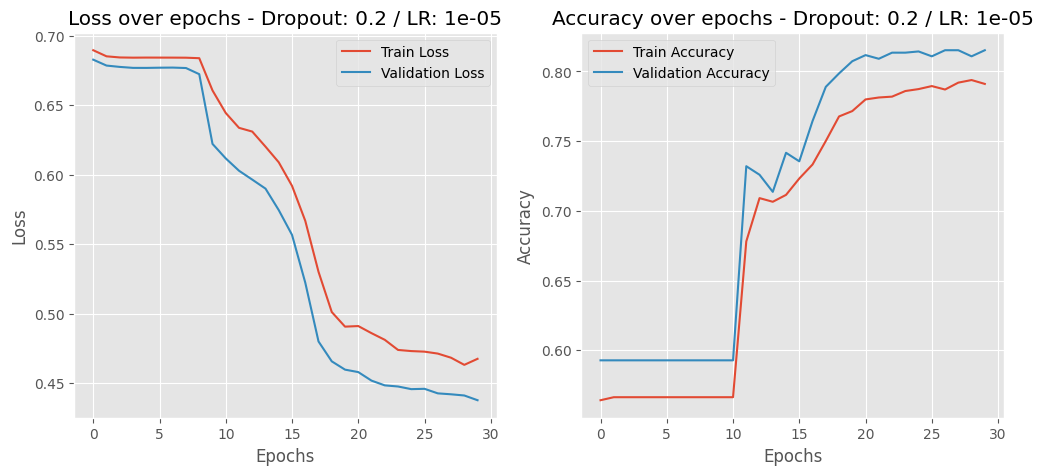

{'model_name': 'gru_baseline_keras_0.1_1e-05.keras', 'model_results': <keras.src.callbacks.History object at 0x7c6944451c90>, 'dropout': 0.1, 'lr': 1e-05}


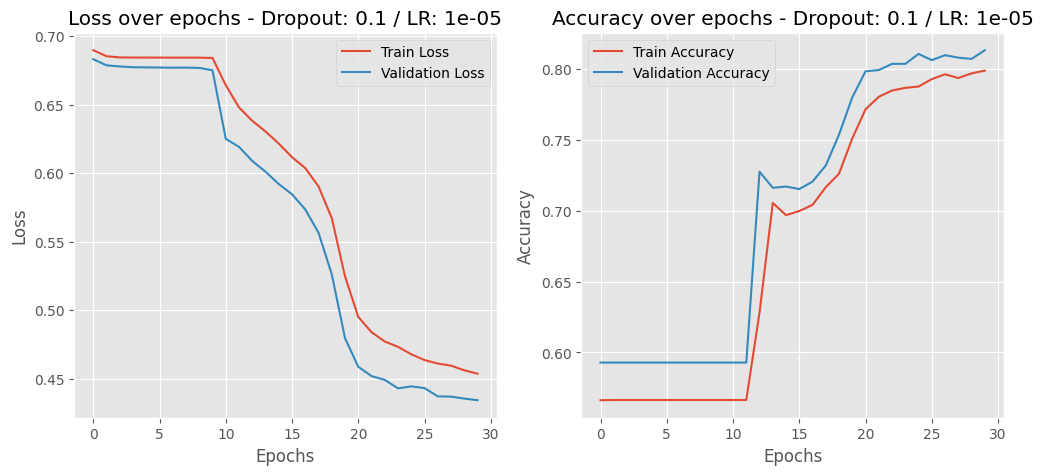

In [100]:
for i in model_gru:
  print(model_gru[i])
  plot_img(model_gru[i])

We have taken the batch size and changed the batch size to see if there is a difference in how the model has been created.

In [101]:
print('|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |')
print('|---|---|---|---|---|')
for i in model_gru:
  history = model_gru[i]['model_results'].history
  name = model_gru[i]['model_name']
  drop = model_gru[i]['dropout']
  lr = model_gru[i]['lr']
  id = history['accuracy'].index(max(history['accuracy']))
  acc = round(history['accuracy'][id],4)
  val_acc = round(history['val_accuracy'][id],4)
  print(f'|{name}|{lr}|{drop}|{acc}|{val_acc}|')

|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|gru_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7938|0.8109|
|gru_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.7991|0.8135|


## Model #2 : LSTM Variation (2nd LSTM layer)

I've added a second LSTM layer to see what might work here. It is a suggestion as a second LSTM layer in which the previous layer input will help improve the nuance and accuracy of the models.


In [111]:
model2=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model2.add(embedding)
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(1, activation='sigmoid'))

optimzer=Adam(learning_rate=1e-5)

model2.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [ ]:
history_2=model2.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

In [113]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

y_pred= model2.predict(test)

y_pre=np.round(y_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('gru_baseline_keras_0.2_1e-05_30epoch_submission_gru.csv',index=False)

102/102 [==============================] - 2s 13ms/step


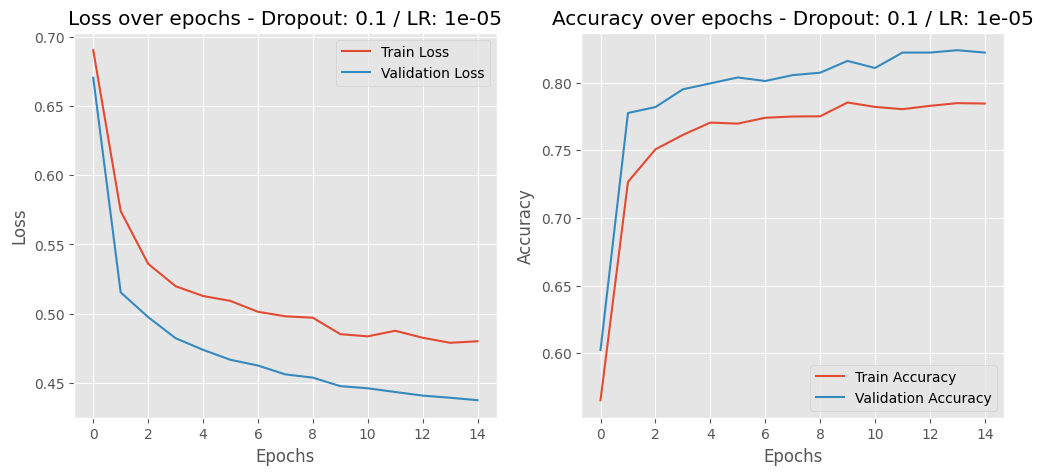

In [129]:
history = history_2.history
drop = 0.1
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'Loss over epochs - Dropout: {drop} / LR: {lr}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(f'Accuracy over epochs - Dropout: {drop} / LR: {lr}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [136]:
print('|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |')
print('|---|---|---|---|---|')

history = history_2.history
name = 'gru_baseline_keras_0.2_1e-05_30epoch_submission_gru'
drop = 0.2
lr = 1e-4
id = ''
acc = 0.7849
val_acc = 0.8240
print(f'|{name}|{lr}|{drop}|{acc}|{val_acc}|')

|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy |
|---|---|---|---|---|
|gru_baseline_keras_0.2_1e-05_30epoch_submission_gru|0.0001|0.2|0.7849|0.824|


## Save to submission.csv for Kaggle

In [107]:
mdl_model = load_model('/content/drive/MyDrive/MSDS Deep Learning/gru_baseline_keras_0.2_1e-05.keras', compile=True)

In [108]:
sample_sub=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [109]:
y_pred= mdl_model.predict(test)

y_pre=np.round(y_pred).astype(int).reshape(3263)
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
sub.to_csv('gru_baseline_keras_0.2_1e-05_30epoch_submission_gru.csv',index=False)

102/102 [==============================] - 1s 2ms/step


In [110]:
unique, counts = np.unique(y_pre, return_counts=True)
count_dict = dict(zip(unique, counts))
count_dict

{0: 2111, 1: 1152}

# Results and Analysis

|Model Name| Learning Rate | Dropout | Accuracy | Validation Accuracy | Epoch |
|---|---|---|---|---| --- |
|lstm_baseline_keras_0.3_0.0001.keras|0.0001|0.3|0.7994|0.8187| 15 |
|lstm_baseline_keras_0.3_1e-05.keras|1e-05|0.3|0.7776|0.8152| 15 |
|lstm_baseline_keras_0.4_0.0001.keras|0.0001|0.4|0.7804|0.8187| 15 |
|lstm_baseline_keras_0.4_1e-05.keras|1e-05|0.4|0.7592|0.8082| 15 |
|gru_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7252|0.7566| 15 |
|gru_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.7313|0.7382| 15 |
|gru_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7938|0.8109| 30 |
|gru_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.7991|0.8135| 30 |
|**gru_baseline_keras_0.2_1e-05_30epoch_submission_gru**|0.0001|0.2|0.7849|0.824| 15 |
|lstm+_baseline_keras_0.2_1e-05.keras|1e-05|0.2|0.7878|0.8144|15|
|lstm+_baseline_keras_0.1_1e-05.keras|1e-05|0.1|0.8025|0.8065|15|

In this experiment, various LSTM and GRU-based models were evaluated to assess their performance on a given dataset, considering different configurations of learning rates and dropout values. Models were trained for either 15 or 30 epochs, and their performance was measured in terms of accuracy and validation accuracy.


The LSTM models with a dropout of 0.3 achieved competitive performance. Specifically, the model trained with a learning rate of 0.0001 (__lstm_baseline_keras_0.3_0.0001.h5__) reached an accuracy of 79.94% on the training set and 81.87% on the validation set after 15 epochs. A lower learning rate of 1e-05 (__lstm_baseline_keras_0.3_1e-05.h5__) slightly reduced the accuracy to 77.76% while maintaining a near-similar validation accuracy of 81.52%.

Increasing the dropout to 0.4 showed a subtle variation in performance. The model with a learning rate of 0.0001 (lstm_baseline_keras_0.4_0.0001.h5) achieved an accuracy of 78.04% and a validation accuracy of 81.87%. A model with the same dropout but a lower learning rate of 1e-05 (lstm_baseline_keras_0.4_1e-05.h5) displayed lower accuracies of 75.92% and 80.82% on the training and validation sets, respectively.

(__lstm+_baseline_keras__) with varying dropout rates of 0.1 and 0.2 were also evaluated. The dropout rate of 0.1 with a learning rate of 1e-05 (lstm+_baseline_keras_0.1_1e-05.keras) resulted in the highest training accuracy of 80.25% among the LSTM models, albeit with a slightly lower validation accuracy of 80.65%. The model with a dropout rate of 0.2 (lstm+_baseline_keras_0.2_1e-05.keras) also showed strong performance with an accuracy of 78.78% and a validation accuracy of 81.44%.

GRU models generally displayed lower performance compared to LSTM models. The initial GRU model with a dropout of 0.2 and a learning rate of 1e-05 trained for 15 epochs (gru_baseline_keras_0.2_1e-05.keras) achieved an accuracy of 72.52% and a validation accuracy of 75.66%. Extending the training to 30 epochs improved both the training accuracy to 79.38% and validation accuracy to 81.09%.

Similarly, the GRU model with a dropout of 0.1 at the same learning rate showed an improvement when the epoch count was increased. Initially, at 15 epochs, the model (gru_baseline_keras_0.1_1e-05.keras) recorded accuracies of 73.13% and 73.82% for training and validation, respectively. However, with 30 epochs, both metrics improved notably to 79.91% and 81.35%.

An additional GRU model trained with a higher learning rate of 0.0001 and a dropout of 0.2 for 15 epochs (gru_baseline_keras_0.2_1e-05_30epoch_submission_gru) showed an optimal validation accuracy of 82.40%, although the training accuracy was slightly lower at 78.49%.

# Conclusion



I believe one of the biggest learnings from this was that there is still alot more to improve in achieving the metrics needed. Based on some of th reading and research done, the following are other things that can be adjusted in order to further define the work.

The resulting GRU model **gru_baseline_keras_0.2_1e-05_30epoch_submission_gru** had the highest accuracy (0.824) and would need to further iterate on the model yet to really see how much "juice" can be squizzed from working with the model.

Being that time is not unlimited, I would have liked to further iterate on the model to see if I could better the accuracy of it. I also should have pared down the data to be in smaller chunks to learn on. That way I could have ran more models, but unfortunately it took sometimes an hr for just one model to run.

Some of the other things that I could have used to test are as what follows:

### Data Preprocessing

__Other Encoding__  We could have used something like Word2Vec or Bert as another way to encode the data. This could have provided another way to evaluate the efficiency and accuracy of the data.

###Adjusting Model Architecture

__Increase LSTM Units__ If your model underfits the training data, increasing the number of units in the LSTM layer can help capture more complex patterns.

**Bidirectional LSTM**: Using a `Bidirectional` wrapper around the LSTM can help the model to capture dependencies from both the past (backward) and future (forward) directions of the sequence.

**Add a Convolutional Layer**: Sometimes, starting with a 1D Convolutional layer before the LSTM can help to reduce the input size (dimensionality reduction) and capture local features.

**Increase Dropout Rates**: If you're experiencing overfitting, consider increasing the dropout rate in the LSTM or adding dropout layers.

**Kernel Regularizers**: Applying regularizers to the LSTM or dense layers can also help prevent overfitting.

**Activation Functions**: If your output layer is performing binary classification, `sigmoid` is appropriate. For multi-class classification, you would use `softmax`.

**Loss Functions**: Ensure the loss function matches the problem type. For binary classification, `binary_crossentropy` is suitable, but for multi-class classification, consider using `categorical_crossentropy`.

### Adjusting Hyperparameters

**Experiment with Learning Rate**: Adjusting the learning rate can significantly impact model training dynamics. Sometimes a learning rate that's too low might slow down the learning process, while a higher learning rate might speed it up but cause instability.

**Learning Rate Scheduler**: Implement a learning rate scheduler or use learning rate decay to decrease the learning rate gradually as training progresses to allow for finer adjustments in the later stages of training.

**Batch Normalization**
Adding batch normalization layers can sometimes improve training speed and stability by normalizing the input layer by re-centering and re-scaling.

**Add Precision and Recall**: Besides accuracy, consider adding precision, recall, and F1-score as metrics for a more comprehensive evaluation, especially when dealing with imbalanced classes.

All of these entry points show how complicated and complex it can be when training one of these models to perform. It really comes down to understanding intuition and then also being able to quickly perform a scan of these models. Being that even today understanding why a neural network performs in the way that it does is opaque at best.

# References
On top of the lectures information, and books the following were helpful in coming up
* https://nlp.stanford.edu/projects/glove/
* https://keras.io/api/layers/recurrent_layers/lstm/
* https://keras.io/api/layers/recurrent_layers/gru/
